In [3]:
import pandas as pd
dataset_url = "https://git.io/nlp-with-transformers"
df_issues = pd.read_json(dataset_url, lines=True)
print(f"DataFrame shape: {df_issues.shape}")

DataFrame shape: (9930, 26)


In [4]:
df_issues["labels"] = (
    df_issues["labels"].apply(lambda x: [meta["name"] for meta in x]))
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [5]:
df_issues["labels"].apply(lambda x : len(x)).value_counts().to_frame().T

,0,1,2,3,4,5
labels,6440,3057,305,100,25,3


In [6]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")
# Display the top-8 label categories
df_counts.to_frame().head(8).T

Number of labels: 65


,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
labels,2284,649,106,98,64,52,50,46


In [7]:
label_map = {"Core: Tokenization": "tokenization",
             "New model": "new model",
             "Core: Modeling": "model training",
             "Usage": "usage",
             "Core: Pipeline": "pipeline",
             "TensorFlow": "tensorflow or tf",
             "PyTorch": "pytorch",
             "Examples": "examples",
             "Documentation": "documentation"}

def filter_labels(x):
  return [label_map[label] for label in x if label in label_map]

df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())

In [8]:
df_counts = df_issues["labels"].explode().value_counts()
df_counts.to_frame().T

,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
labels,106,98,64,46,42,41,37,28,24


In [9]:
df_issues["split"] = "unlabeled"
mask = df_issues["labels"].apply(lambda x: len(x)) > 0
df_issues.loc[mask, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,split
unlabeled,9489
labeled,441


In [10]:
for column in ["title", "body", "labels"]:
  print(f"{column}: {df_issues[column].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



In [11]:
df_issues["text"] = (
    df_issues.apply(lambda x: x["title"] + "\n\n" + x["body"], axis=1))

In [12]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"Removed {(len_before-len(df_issues))/len_before:.2%} duplicates.")

Removed 1.88% duplicates.


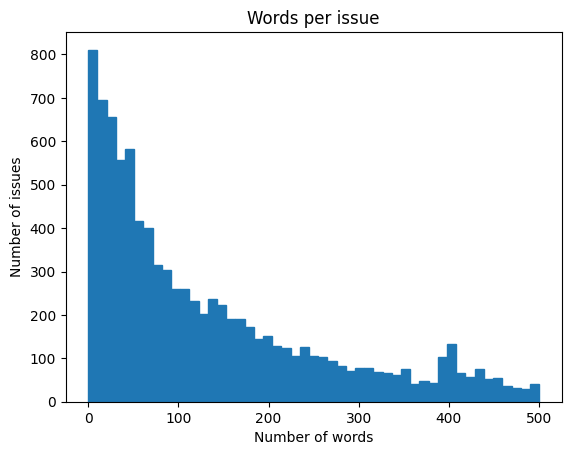

In [13]:
import numpy as np
import matplotlib.pyplot as plt

(df_issues["text"].str.split().apply(len)
  .hist(bins=np.linspace(0, 500, 50), grid=False, edgecolor="C0"))

plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

## Creating Training Sets

In [14]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [15]:
!pip install scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.1 MB/s eta 0:00:00


In [16]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
  ind = np.expand_dims(np.arange(len(df)), axis=1)
  labels = mlb.transform(df["labels"])
  ind_train, _, ind_test, _ = iterative_train_test_split(
      ind, labels,test_size)
  return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]

In [17]:
from sklearn.model_selection import train_test_split
df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]
np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [18]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 12.2 MB/s eta 0:00:00


 A `defaultdict` provides a default value for missing keys, which can be very useful in scenarios like label encoding, one-hot encoding, or any situation where you need to count occurrences or transform data.

 For instance, if you encounter a label that's not in the dictionary, a `defaultdict` allows you to provide a default value (typically 0) rather than raising an error.

In [19]:
from datasets import Dataset, DatasetDict
ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))})

- We’ll start with only eight samples per label and build up until the slice covers the full training set using the `iterative_train_test_split()` function:
- `all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)`
This line creates an array all_indices containing a range of integers from 0 to the length of the training dataset `ds["train"]`. The `np.expand_dims` function is used to convert this array into a column vector.

In [20]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
  # Split off samples necessary to fill the gap to the next split size
  indices_pool, labels, new_slice, _ = iterative_train_test_split(
      indices_pool, labels, (k-last_k)/len(labels))
  last_k = k
  if i==0: train_slices.append(new_slice)
  else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))

# Add full dataset as last slice
train_slices.append(all_indices), train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

In [21]:
# For example, if train_samples contains the values [8, 16, 32], the code will attempt to create training slices of sizes 8, 16, and 32, respectively.
# However, the actual training slice sizes may be slightly larger or smaller than these values due to the approximation
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])

Target split sizes:
[8, 16, 32, 64, 128, 223]
Actual split sizes:
[10, 19, 36, 68, 134, 223]


In [22]:
# multilabel binarizer to create a new label_ids column in our training sets
def prepare_labels(batch):
  batch["label_ids"] = mlb.transform(batch["labels"])
  return batch
ds = ds.map(prepare_labels, batched=True)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [23]:
from collections import defaultdict
macro_scores, micro_scores = defaultdict(list), defaultdict(list)

`BinaryRelevance` trains a separate binary classifier for each label and model each label independently.

`countVectorizer` :

"This is the first document" is encoded as [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
"Another document here" is encoded as [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]
"A third document" is encoded as [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0]
"And one more" is encoded as [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]

--- These count vectors represent the frequency of each word in each document and can be used as input features for machine learning models `bag-of-words approach` ---

`classification_report` is used to generate a report of various classification metrics such as precision, recall, F1-score, and support for each label. It's used to evaluate the performance of the multi-label classification model, between `y_test` (the true labels) and `y_pred_test` (the predicted labels)

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
  # Get training slice and test data
  ds_train_sample = ds["train"].select(train_slice)
  y_train = np.array(ds_train_sample["label_ids"])
  y_test = np.array(ds["test"]["label_ids"])
  # Use a simple count vectorizer to encode our texts as token counts
  count_vect = CountVectorizer()
  X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
  X_test_counts = count_vect.transform(ds["test"]["text"])
  # Create and train our model!
  classifier = BinaryRelevance(classifier=MultinomialNB())
  classifier.fit(X_train_counts, y_train)
  # Generate predictions and evaluate
  y_pred_test = classifier.predict(X_test_counts)
  clf_report = classification_report(
      y_test, y_pred_test, target_names=mlb.classes_,
      zero_division=0, output_dict=True)
  # Store metrics
  macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
  micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

### Macro Scores:
- computes individual metrics (e.g., precision, recall, F1-score) for each label or class and then taking the average of these metrics across all labels.
- Each label is treated equally in the calculation, regardless of its prevalence in the dataset.
- scores provide an equal-weighted average of performance across all labels.

### Micro Scores:
- are calculated by considering the global count of true positives, false positives, and false negatives for all labels and then deriving metrics (e.g., precision, recall, F1-score) based on these global counts.
- metrics are calculated as if all instances belong to a single multi-label classification problem
- scores provide an aggregate measure of overall performance across all labels, giving more weight to labels with more instances.

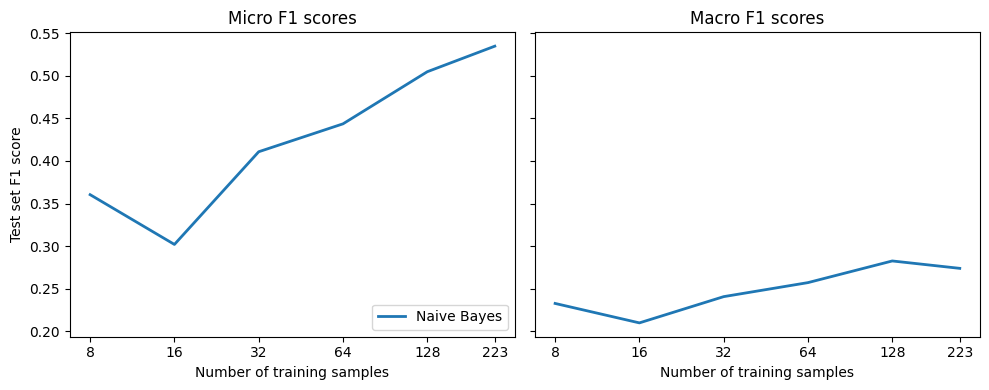

In [25]:
import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
  for run in micro_scores.keys():
    if run == current_model:
      ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
      ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
    else:
      ax0.plot(sample_sizes, micro_scores[run], label=run, linestyle="dashed")
      ax1.plot(sample_sizes, macro_scores[run], label=run, linestyle="dashed")
  ax0.set_title("Micro F1 scores")
  ax1.set_title("Macro F1 scores")
  ax0.set_ylabel("Test set F1 score")
  ax0.legend(loc="lower right")
  for ax in [ax0, ax1]:
    ax.set_xlabel("Number of training samples")
    ax.set_xscale("log")
    ax.set_xticks(sample_sizes)
    ax.set_xticklabels(sample_sizes)
    ax.minorticks_off()
  plt.tight_layout()
  plt.show()
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")
# we can see that the micro and macro F1-scores both improve as we increase
# the number of training samples.

### Working with No Labeled Data `zero-shot-learning`

In [26]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0


In [27]:
from transformers import pipeline
pipe = pipeline("fill-mask", model="bert-base-uncased")

(…)rt-base-uncased/resolve/main/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(…)cased/resolve/main/tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

(…)bert-base-uncased/resolve/main/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)base-uncased/resolve/main/tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [28]:
movie_desc = "The main characters of the movie madacascar \
are a lion, a zebra, a giraffe, and a hippo. "
prompt = "The movie is about [MASK]."
output = pipe(movie_desc + prompt)
for element in output:
  print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:	0.103%
Token lions:	0.066%
Token birds:	0.025%
Token love:	0.015%
Token hunting:	0.013%


In [29]:
output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
  print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:	0.103%
Token cars:	0.001%


In [30]:
movie_desc = "In the movie transformers aliens \
can morph into a wide range of vehicles."
output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
  print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token cars:	0.139%
Token animals:	0.006%


### MNLI model for zero-shot classification

In [31]:
from transformers import pipeline
pipe = pipeline("zero-shot-classification", device=0)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


(…)bart-large-mnli/resolve/main/config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

(…)-mnli/resolve/main/tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

(…)/bart-large-mnli/resolve/main/vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

(…)/bart-large-mnli/resolve/main/merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

(…)t-large-mnli/resolve/main/tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [32]:
sample = ds["train"][0]
print(f"Labels: {sample['labels']}")
output = pipe(sample["text"], all_labels, multi_label=True)
print(output["sequence"][:400])
print("\nPredictions:")
for label, score in zip(output["labels"], output["scores"]):
  print(f"{label}, {score:.2f}")

Labels: ['new model']
Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokeni

Predictions:
new model, 0.98
tensorflow or tf, 0.37
examples, 0.34
usage, 0.30
pytorch, 0.25
documentation, 0.25
model training, 0.24
tokenization, 0.17
pipeline, 0.16


In [33]:
def zero_shot_pipeline(example):
  output = pipe(example["text"], all_labels, multi_label=True)
  example["predicted_labels"] = output["labels"]
  example["scores"] = output["scores"]
  return example
ds_zero_shot = ds["valid"].map(zero_shot_pipeline)

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


###determine which set of labels should be assigned to each example, two approaches:
- Define a threshold and select all labels above the threshold.
- Pick the top k labels with the k highest scores.

To help us determine which method is best `get_preds()`

In [34]:
def get_preds(example, threshold=None, topk=None):
  preds = []
  if threshold:
    for label, score in zip(example["predicted_labels"], example["scores"]):
      if score >= threshold:
        preds.append(label)
  elif topk:
      for i in range(topk):
        preds.append(example["predicted_labels"][i])
  else:
    raise ValueError("Set either `threshold` or `topk`.")
  return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

`get_clf_report()` returns the Scikit-learn classification report from a dataset with the predicted labels

In [35]:
def get_clf_report(ds):
  y_true = np.array(ds["label_ids"])
  y_pred = np.array(ds["pred_label_ids"])
  return classification_report(
        y_true, y_pred, target_names=mlb.classes_,
        zero_division=0,output_dict=True)

start with the top-k method by increasing k for several values and then plotting the micro and macro F1-scores across the validation set

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

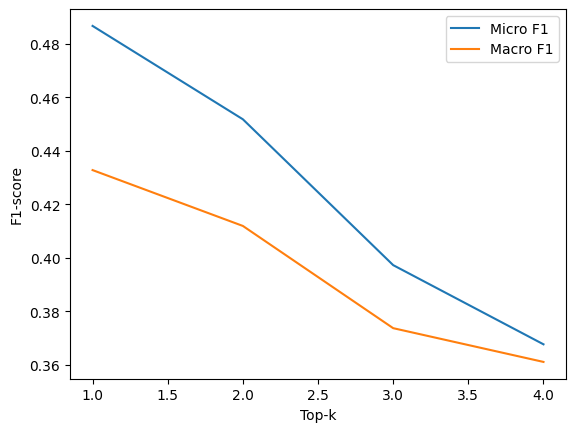

In [36]:
macros, micros = [], []
topks = [1, 2, 3, 4]
for topk in topks:
  ds_zero_shot = ds_zero_shot.map(get_preds, batched=False,
  fn_kwargs={'topk': topk})
  clf_report = get_clf_report(ds_zero_shot)
  micros.append(clf_report['micro avg']['f1-score'])
  macros.append(clf_report['macro avg']['f1-score'])
plt.plot(topks, micros, label='Micro F1')
plt.plot(topks, macros, label='Macro F1')
plt.xlabel("Top-k")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()

now compare this against setting a threshold

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

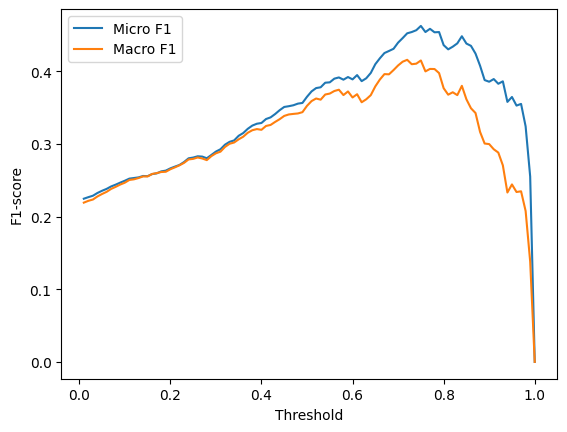

In [37]:
macros, micros = [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
  ds_zero_shot = ds_zero_shot.map(
      get_preds,
      fn_kwargs={"threshold": threshold})
  clf_report = get_clf_report(ds_zero_shot)
  micros.append(clf_report["micro avg"]["f1-score"])
  macros.append(clf_report["macro avg"]["f1-score"])
plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()

In [38]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'Best threshold (micro): {best_t} with F1-score {best_macro:.2f}.')

Best threshold (micro): 0.75 with F1-score 0.46.
Best threshold (micro): 0.72 with F1-score 0.42.


compare zero-shot classification against Naive Bayes on the test set

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Map:   0%|          | 0/111 [00:00<?, ? examples/s]

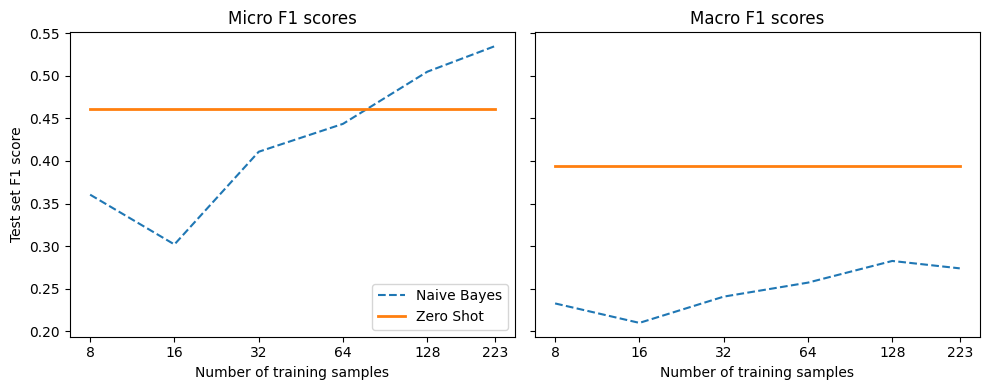

In [39]:
ds_zero_shot = ds['test'].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={'topk': 1})
clf_report = get_clf_report(ds_zero_shot)
for train_slice in train_slices:
  macro_scores['Zero Shot'].append(clf_report['macro avg']['f1-score'])
  micro_scores['Zero Shot'].append(clf_report['micro avg']['f1-score'])
plot_metrics(micro_scores, macro_scores, train_samples, "Zero Shot")

In [40]:
# ds_zero_shot = ds['test'].map(zero_shot_pipeline)
# ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={'threshold': 0.75})
# clf_report = get_clf_report(ds_zero_shot)
# for train_slice in train_slices:
#   macro_scores['Zero Shot'].append(clf_report['macro avg']['f1-score'])
#   micro_scores['Zero Shot'].append(clf_report['micro avg']['f1-score'])
# plot_metrics(micro_scores, macro_scores, train_samples, "Zero Shot")

## Few labels
### Augmentation
- back translation
- token perturbations (Synonym replace - Random insert - Random swap - Random delete)

In [41]:
!pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 5.7 MB/s eta 0:00:00


In [42]:
from transformers import set_seed
import nlpaug.augmenter.word as naw
set_seed(3)
aug = naw.ContextualWordEmbsAug(
    model_path="distilbert-base-uncased",device="cpu", action="substitute")
text = "Transformers are the most popular toys"
print(f"Original text: {text}")
print(f"Augmented text: {aug.augment(text)}")

(…)cased/resolve/main/tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

(…)rt-base-uncased/resolve/main/config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

(…)bert-base-uncased/resolve/main/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)base-uncased/resolve/main/tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Original text: Transformers are the most popular toys
Augmented text: ['transformers produce the most durable toys']


In [43]:
def augment_text(batch, transformations_per_example=1):
  text_aug, label_ids = [], []
  for text, labels in zip(batch["text"], batch["label_ids"]):
    text_aug += [text]
    label_ids += [labels]
    for _ in range(transformations_per_example):
      text_aug += [aug.augment(text)]
      label_ids += [labels]
  return {"text": text_aug, "label_ids": label_ids}

 the augmented text is now included in the dataset, we remove the original text and label columns to avoid redundancy and to save memory

In [44]:
# ds_train_sample = ds_train_sample.map(
#     augment_text, batched=True,
#     remove_columns=ds_train_sample.column_names).shuffle(seed=42)

In [45]:
# plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes + Aug")

The "attention_mask" is used to mask (ignore) certain tokens in the input sequence, typically the padding tokens, By multiplying the token embeddings with the "attention_mask," the model ensures that the embeddings of the masked tokens do not contribute to further processing or calculations.

Finally, the code returns the average of the non-masked token embeddings as a single vector.

`unsqueeze` the attention mask is to change its shape by adding an extra dimension to the tensor.

In [46]:
import torch
from transformers import AutoTokenizer, AutoModel
model_ckpt = "miguelvictor/python-gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
def mean_pooling(model_output, attention_mask):
  # Extract the token embeddings
  token_embeddings = model_output[0]
  # Compute the attention mask
  input_mask_expanded = (
      attention_mask.unsqueeze(-1)
      .expand(token_embeddings.size())
      .float())
  # Sum the embeddings, but ignore masked tokens
  sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
  # clamp insures dominator is never zero
  sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
  # Return the average as a single vector
  return sum_embeddings / sum_mask
def embed_text(examples):
  inputs = tokenizer(
      examples["text"],
      padding=True,
      truncation=True,
      max_length=128,
      return_tensors="pt")
  with torch.no_grad():
    model_output = model(**inputs)
  pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
  return {"embedding": pooled_embeds.cpu().numpy()}

(…)thon-gpt2-large/resolve/main/config.json:   0%|          | 0.00/792 [00:00<?, ?B/s]

(…)ython-gpt2-large/resolve/main/vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

(…)ython-gpt2-large/resolve/main/merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

(…)n-gpt2-large/resolve/main/tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

For example, if you have a text sequence like `Hello, world` and you pad it to a fixed length of 10 tokens, with this setting, the padding tokens added to the end of the sequence will be represented as eos_token tokens:

Original sequence: "Hello, world"
After padding: `Hello, world [eos_token] [eos_token] [eos_token] [eos_token] [eos_token]`

In [47]:
tokenizer.pad_token = tokenizer.eos_token
embs_train = ds["train"].map(embed_text, batched=True, batch_size=16)
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=16)
embs_test = ds["test"].map(embed_text, batched=True, batch_size=16)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

`FAISS` library for similarity search with embeddings in a dataset, it helps you find similar items or data points based on their vector representations (embeddings).

`add_faiss_index()` create a FAISS index using an existing field in your dataset, `add_faiss_index_from_external_arrays()` load new embeddings from external sources to build a FAISS index

In [48]:
!pip install faiss-gpu
# !pip install faiss-cpu

In [49]:
embs_train.add_faiss_index("embedding")

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['text', 'labels', 'label_ids', 'embedding'],
    num_rows: 223
})

In [50]:
i, k = 0, 3 # Select the first query and 3 nearest neighbors
rn, nl = "\r\n\r\n", "\n" # Used to remove newlines in text for compact display

query = np.array(embs_valid[i]["embedding"], dtype=np.float32)
scores, samples = embs_train.get_nearest_examples("embedding", query, k=k)

print(f"QUERY LABELS: {embs_valid[i]['labels']}")
print(f"QUERY TEXT:\n{embs_valid[i]['text'][:200].replace(rn, nl)} [...]\n")
print("="*50)
print(f"Retrieved documents:")
for score, label, text in zip(scores, samples["labels"], samples["text"]):
  print("="*50)
  print(f"TEXT:\n{text[:200].replace(rn, nl)} [...]")
  print(f"SCORE: {score:.2f}")
  print(f"LABELS: {label}")

QUERY LABELS: ['new model']
QUERY TEXT:
Implementing efficient self attention in T5

# 🌟 New model addition
My teammates and I (including @ice-americano) would like to use efficient self attention methods such as Linformer, Performer and [...]

Retrieved documents:
TEXT:
Add Linformer model

# 🌟 New model addition
## Model description
### Linformer: Self-Attention with Linear Complexity
Paper published June 9th on ArXiv: https://arxiv.org/abs/2006.04768
La [...]
SCORE: 54.92
LABELS: ['new model']
TEXT:
Add FAVOR+ / Performer attention

# 🌟 FAVOR+ / Performer attention addition
Are there any plans to add this new attention approximation block to Transformers library?
## Model description
The n [...]
SCORE: 57.90
LABELS: ['new model']
TEXT:
Implement DeLighT: Very Deep and Light-weight Transformers

# 🌟 New model addition
## Model description
DeLight, that delivers similar or better performance than transformer-based models with sign [...]
SCORE: 60.12
LABELS: ['new model']


The combination of the two loops systematically evaluates the performance of the label aggregation process for a range of document retrieval scenarios (controlled by "k") and label aggregation strategies (controlled by "m"). This approach helps in finding the optimal values for "k" and "m" that result in the best label aggregation quality, as measured by F1-scores. It allows you to analyze how different combinations of "k" and "m" impact the trade-off between precision and recall in the document retrieval and label aggregation process.

In [51]:
def get_sample_preds(sample, m):
  return (np.sum(sample["label_ids"], axis=0) >= m).astype(int)

def find_best_k_m(ds_train, valid_queries, valid_labels, max_k=17):
  max_k = min(len(ds_train), max_k)
  perf_micro = np.zeros((max_k, max_k))
  perf_macro = np.zeros((max_k, max_k))
  for k in range(1, max_k):
    for m in range(1, k + 1):
      _, samples = ds_train.get_nearest_examples_batch("embedding",
      valid_queries, k=k)
      y_pred = np.array([get_sample_preds(s, m) for s in samples])
      clf_report = classification_report(valid_labels, y_pred,
      target_names=mlb.classes_, zero_division=0, output_dict=True)
      perf_micro[k, m] = clf_report["micro avg"]["f1-score"]
      perf_macro[k, m] = clf_report["macro avg"]["f1-score"]
  return perf_micro, perf_macro

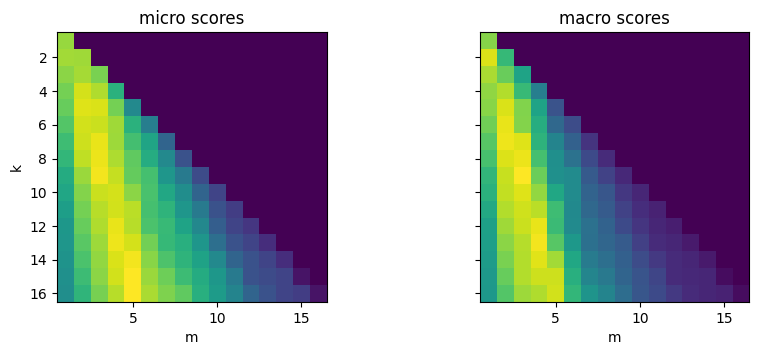

In [52]:
valid_labels = np.array(embs_valid["label_ids"])
valid_queries = np.array(embs_valid["embedding"], dtype=np.float32)
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labels)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax0.imshow(perf_micro)
ax1.imshow(perf_macro)
ax0.set_title("micro scores")
ax0.set_ylabel("k")
ax1.set_title("macro scores")

for ax in [ax0, ax1]:
  ax.set_xlim([0.5, 17 - 0.5])
  ax.set_ylim([17 - 0.5, 0.5])
  ax.set_xlabel("m")

plt.show()

In [52]:
valid_labels = np.array(embs_valid["label_ids"])
valid_queries = np.array(embs_valid["embedding"], dtype=np.float32)
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labels)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax0.imshow(perf_micro)
ax1.imshow(perf_macro)
ax0.set_title("micro scores")
ax0.set_ylabel("k")
ax1.set_title("macro scores")
for ax in [ax0, ax1]:
  ax.set_xlim([0.5, 17 - 0.5])
  ax.set_ylim([17 - 0.5, 0.5])
  ax.set_xlabel("m")
plt.show()

In [53]:
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
print(f"Best k: {k}, best m: {m}")

Best k: 15, best m: 5


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

ValueError: ignored

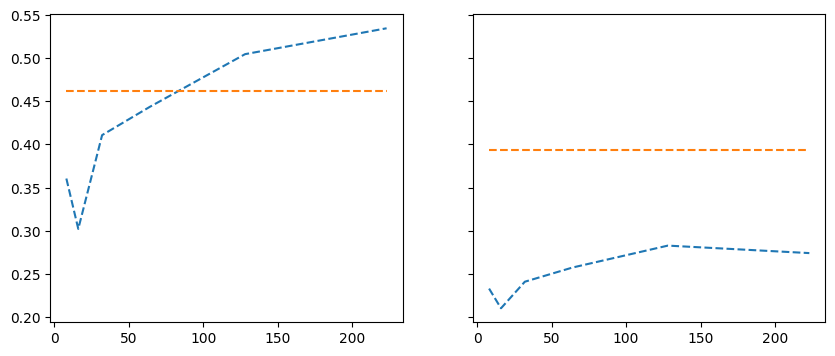

In [59]:
embs_train.drop_index("embedding")
test_labels = np.array(embs_test["label_ids"])
test_queries = np.array(embs_test["embedding"], dtype=np.float32)

for train_slice in train_slices:
  # Create a Faiss index from training slice
  embs_train_tmp = embs_train.select(train_slice)
  embs_train_tmp.add_faiss_index("embedding")
  # Get best k, m values with validation set
  perf_micro, _ = find_best_k_m(embs_train_tmp, valid_queries, valid_labels)
  k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
  # Get predictions on test set
  _, samples = embs_train_tmp.get_nearest_examples_batch(
      "embedding", test_queries, k=int(k))
  y_pred = np.array([get_sample_preds(s, m) for s in samples])
  # Evaluate predictions
  clf_report = classification_report(
      test_labels, y_pred,
      target_names=mlb.classes_,
      zero_division=0,
      output_dict=True,)
  macro_scores["Embedding"].append(clf_report["macro avg"]["f1-score"])
  micro_scores["Embedding"].append(clf_report["micro avg"]["f1-score"])

# plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")

## Fine-Tuning a Vanilla Transformer

In [60]:
import torch
from transformers import (AutoTokenizer, AutoConfig,
AutoModelForSequenceClassification)
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
  return tokenizer(batch["text"], truncation=True, max_length=128)

ds_enc = ds.map(tokenize, batched=True)
ds_enc = ds_enc.remove_columns(['labels', 'text'])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [61]:
ds_enc.set_format("torch")
ds_enc = ds_enc.map(
    lambda x: {"label_ids_f": x["label_ids"].to(torch.float)},
    remove_columns=["label_ids"])
ds_enc = ds_enc.rename_column("label_ids_f", "label_ids")

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [63]:
!pip install accelerate -U

In [64]:
from transformers import Trainer, TrainingArguments
training_args_fine_tune = TrainingArguments(
    output_dir="./results", num_train_epochs=20, learning_rate=3e-5,
    lr_scheduler_type='constant', per_device_train_batch_size=4,
    per_device_eval_batch_size=32, weight_decay=0.0,
    evaluation_strategy="epoch", save_strategy="epoch",logging_strategy="epoch",
    load_best_model_at_end=True, metric_for_best_model='micro f1',
    save_total_limit=1, log_level='error'
    )

ImportError: ignored

In [ ]:
from scipy.special import expit as sigmoid
def compute_metrics(pred):
  y_true = pred.label_ids
  y_pred = sigmoid(pred.predictions)
  y_pred = (y_pred>0.5).astype(float)
  clf_dict = classification_report(
      y_true, y_pred,
      target_names=all_labels,
      zero_division=0,
      output_dict=True
      )
  return {
      "micro f1": clf_dict["micro avg"]["f1-score"],
      "macro f1": clf_dict["macro avg"]["f1-score"]
      }

In [ ]:
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

for train_slice in train_slices:
  model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
  config=config)
  trainer = Trainer(
  model=model, tokenizer=tokenizer,
  args=training_args_fine_tune,
  compute_metrics=compute_metrics,
  train_dataset=ds_enc["train"].select(train_slice),
  eval_dataset=ds_enc["valid"],)
  trainer.train()
  pred = trainer.predict(ds_enc["test"])
  metrics = compute_metrics(pred)
  macro_scores["Fine-tune (vanilla)"].append(metrics["macro f1"])
  micro_scores["Fine-tune (vanilla)"].append(metrics["micro f1"])

plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (vanilla)")

### Fine-Tuning the pretrained BERT model with masked language modeling on the unlabeled portion of our dataset

we don’t train the model to also predict these tokens [CLS] and [SEP], we mask them from the loss, we can get a mask when tokenizing by setting
return_special_tokens_mask=True

Steps:
- we make a copy from the original `ds` data as `ds_mlm` data and remove from it `["labels", "text", "label_ids"]` to train the bert model on it to learn to predict masked tokens using the `data_locator`
- then we use the model that we just trained back on the original `ds` dataset to see the difference in accuracy between fine-tuning a vanilla transformer and fine-tuning a fine-tuned masked language model  

In [ ]:
def tokenize(batch):
  return tokenizer(batch["text"],
                   truncation=True,
                   max_length=128,
                   return_special_tokens_mask=True)
ds_mlm = ds.map(tokenize, batched=True)
ds_mlm = ds_mlm.remove_columns(["labels", "text", "label_ids"])

In [ ]:
from transformers import DataCollatorForLanguageModeling, set_seed
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm_probability=0.15)

In [ ]:
set_seed(3)
data_collator.return_tensors = "np"
inputs = tokenizer("Transformers are awesome!", return_tensors="np")
outputs = data_collator([{"input_ids": inputs["input_ids"][0]}])
pd.DataFrame({
    "Original tokens": tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]),
    "Masked tokens": tokenizer.convert_ids_to_tokens(outputs["input_ids"][0]),
    "Original input_ids": original_input_ids,
    "Masked input_ids": masked_input_ids,
    "Labels": outputs["labels"][0]}).T

In [ ]:
data_collator.return_tensors = "pt"

In [ ]:
from transformers import AutoModelForMaskedLM

training_args = TrainingArguments(
    output_dir = f"{model_ckpt}-issues-128",
    per_device_train_batch_size=32,
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="no",
    num_train_epochs=16,
    push_to_hub=True, log_level="error",
    report_to="none")

trainer = Trainer(
    model=AutoModelForMaskedLM.from_pretrained("bert-base-uncased"),
    tokenizer=tokenizer, args=training_args, data_collator=data_collator,
    train_dataset=ds_mlm["unsup"], eval_dataset=ds_mlm["train"])

trainer.train()
trainer.push_to_hub("Training complete!")

In [ ]:
df_log = pd.DataFrame(trainer.state.log_history)

 (df_log.dropna(subset=["eval_loss"]).reset_index()["eval_loss"]
  .plot(label="Validation"))

df_log.dropna(subset=["loss"]).reset_index()["loss"].plot(label="Train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

Fine-Tuning a Classifier useing the latest pretrained BERT model on masked language.

In [ ]:
model_ckpt = f'{model_ckpt}-issues-128'
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"
for train_slice in train_slices:
  model = AutoModelForSequenceClassification.from_pretrained(
      model_ckpt,config=config)
  trainer = Trainer(
      model=model,
      tokenizer=tokenizer,
      args=training_args_fine_tune,
      compute_metrics=compute_metrics,
      train_dataset=ds_enc["train"].select(train_slice),
      eval_dataset=ds_enc["valid"],
  )
  trainer.train()
  pred = trainer.predict(ds_enc['test'])
  metrics = compute_metrics(pred)
  # DA refers to domain adaptation
  macro_scores['Fine-tune (DA)'].append(metrics['macro f1'])
  micro_scores['Fine-tune (DA)'].append(metrics['micro f1'])

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (DA)")